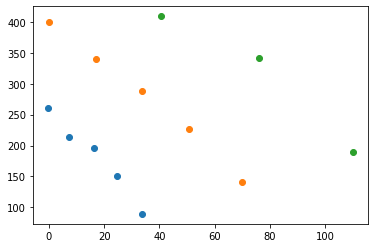

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel("DarleyDaleDataset.xlsx")
df["Sig3_MPa"] = df.S3_MPa - df.Pp_MPa
df["Sig1_MPa"] = df.S1_MPa - df.Pp_MPa
# Filter values beyond the linearity
df = df[df.Sig3_MPa < 100]

fig, ax = plt.subplots()
for name, g in df.groupby('S3_MPa'):
    ax.scatter(g.Pp_MPa, g.S1_MPa)

UCS=80.44 MPa q=4.5881


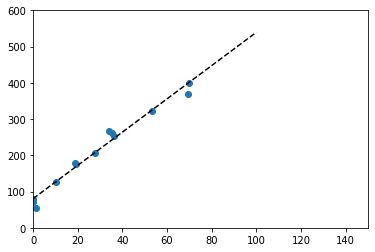

In [27]:



# Optimize Biot
from scipy.stats import linregress
Q, UCS, r_value, p_value, std_err = linregress( df.Sig3_MPa, df.Sig1_MPa )
Sig1_fit = np.linspace(0,100,10)
Sig3_fit = Sig1_fit * Q + UCS

fig, ax = plt.subplots()
ax.scatter(df.Sig3_MPa, df.Sig1_MPa)
ax.plot(Sig1_fit, Sig3_fit, ls='--', color='k')
ax.set_xlim(0,150)
ax.set_ylim(0,600)

print(f"UCS={UCS:.2f} MPa q={Q:.4f}")

S0=18.78 MU=0.8376


(0.0, 100.0)

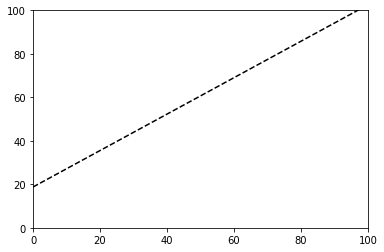

In [34]:
S0 = UCS / 2 / np.sqrt(Q)
MU = (Q-1) / 2 / np.sqrt(Q)

print(f"S0={S0:.2f} MU={MU:.4f}")

xshear=np.linspace(0,100,10)
yshear=S0 + MU * xshear

fig, ax = plt.subplots()
ax.plot(xshear, yshear, ls='--', color='k')
ax.set_xlim(0,100)
ax.set_ylim(0,100)
